In [1]:
# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1
# !pip install pyarrow

In [2]:
import torch
import os
import pickle
from model import ClassificationNet, train_epoch, evaluate_epoch, save_list_to_file, load_list_from_file
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
from dataloader import get_dataloaders, DEVICE

print("Imported successfully!")
print(f"Running on device: {DEVICE}")

BATCH_SIZE = 64
train_dataloader, valid_dataloader, test_dataloader, vocab = get_dataloaders(batch_size=BATCH_SIZE)

# --- Verification Step ---
print("\nVerifying by fetching one batch from train_dataloader...")
labels, texts = next(iter(train_dataloader))

print(f"Labels batch shape: {labels.shape}")
print(f"Texts batch shape: {texts.shape}")

Imported successfully!
Running on device: cuda
Loading data from Parquet files...
Vocabulary Size: 95811

Verifying by fetching one batch from train_dataloader...
Labels batch shape: torch.Size([64])
Texts batch shape: torch.Size([64, 78])


In [4]:
vocab_size = len(vocab)
num_classes = 4

In [5]:
EXPERIMENT_DIR = "runs/adam_from_epoch71"
METRICS_DIR = os.path.join(EXPERIMENT_DIR, "metrics") 
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True) 

print(f"Experiment artifacts will be saved in: {EXPERIMENT_DIR}")
print(f"Metrics will be saved in: {METRICS_DIR}")

Experiment artifacts will be saved in: runs/adam_from_epoch71
Metrics will be saved in: runs/adam_from_epoch71/metrics


In [6]:
model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
# define tits parameters after loading the checkpoint
scheduler = None

In [8]:
start_epoch = 1
best_val_accuracy = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [9]:
BASE_CHECKPOINT_PATH = 'runs/adam_from_epoch51/checkpoint.pth'

In [10]:
if os.path.exists(BASE_CHECKPOINT_PATH):
    print(f"Found base checkpoint. Initializing model with weights from '{BASE_CHECKPOINT_PATH}'...")
    checkpoint = torch.load(BASE_CHECKPOINT_PATH)
    
    model.load_state_dict(checkpoint['model_state_dict']) # Load weights only
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']                       # Continue history
    best_val_accuracy = checkpoint['best_val_accuracy']
    
else:
    print("No checkpoints found. Starting a completely new training run.")

Found base checkpoint. Initializing model with weights from 'runs/adam_from_epoch51/checkpoint.pth'...


In [13]:
EPOCHS = 100            # Train up to a total of 90 epochs

# Configure and assign the CosineAnnealingLR scheduler
# It will run for the remaining epochs (100 - 70 = 30 epochs)

remaining_epochs = EPOCHS - start_epoch + 1
scheduler = CosineAnnealingLR(optimizer, T_max=remaining_epochs, eta_min=1e-7)

print(f"Starting training from epoch {start_epoch}...")

for epoch in range(start_epoch, EPOCHS + 1):
    print("-" * 50)
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # Run training and validation
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    val_loss, val_acc = evaluate_epoch(model, valid_dataloader, criterion, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step()
    
    # Get current LR to print it
    current_lr = optimizer.param_groups[0]['lr']
    
    # summary
    print(f"\nEpoch Summary:")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tValid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")
    print(f"\tLearning Rate: {current_lr:.6f}")

    # Save best model to the experiment folder
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_path = os.path.join(EXPERIMENT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to '{best_model_path}'")

print("-" * 50)
print("Training Finished!")
        
        
# Save final history to the experiment folder
for key, value in history.items():
    file_path = os.path.join(METRICS_DIR, f"{key}.pkl")
    save_list_to_file(value, file_path)

Training:   0%|          | 0/1725 [00:00<?, ?it/s]

Starting training from epoch 71...
--------------------------------------------------
Epoch 71/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 130.79it/s, loss=0.4061]



Epoch Summary:
	Train Loss: 0.4423 | Train Acc: 84.84%
	Valid Loss: 0.4061 | Valid Acc: 86.61%
	Learning Rate: 0.000997


Training:   0%|          | 4/1725 [00:00<00:43, 39.27it/s, loss=0.3962]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 72/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 133.36it/s, loss=0.4000]



Epoch Summary:
	Train Loss: 0.4280 | Train Acc: 85.32%
	Valid Loss: 0.4000 | Valid Acc: 87.24%
	Learning Rate: 0.000989


Training:   0%|          | 5/1725 [00:00<00:41, 41.34it/s, loss=0.4142]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 73/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 127.00it/s, loss=0.3836]



Epoch Summary:
	Train Loss: 0.4203 | Train Acc: 85.63%
	Valid Loss: 0.3836 | Valid Acc: 87.64%
	Learning Rate: 0.000976


Training:   0%|          | 5/1725 [00:00<00:41, 41.27it/s, loss=0.4758]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 74/100


Training:   0%|          | 2/1725 [00:00<01:26, 19.90it/s, loss=0.4572]


Epoch Summary:
	Train Loss: 0.4185 | Train Acc: 85.62%
	Valid Loss: 0.4105 | Valid Acc: 86.25%
	Learning Rate: 0.000957
--------------------------------------------------
Epoch 75/100


Training:   0%|          | 3/1725 [00:00<01:03, 26.99it/s, loss=0.4212]


Epoch Summary:
	Train Loss: 0.4134 | Train Acc: 85.80%
	Valid Loss: 0.3819 | Valid Acc: 87.63%
	Learning Rate: 0.000933
--------------------------------------------------
Epoch 76/100


Training:   0%|          | 3/1725 [00:00<01:04, 26.80it/s, loss=0.3602]


Epoch Summary:
	Train Loss: 0.3971 | Train Acc: 86.53%
	Valid Loss: 0.3698 | Valid Acc: 87.64%
	Learning Rate: 0.000905
--------------------------------------------------
Epoch 77/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 132.81it/s, loss=0.3776]



Epoch Summary:
	Train Loss: 0.3849 | Train Acc: 86.89%
	Valid Loss: 0.3776 | Valid Acc: 88.20%
	Learning Rate: 0.000872


Training:   0%|          | 3/1725 [00:00<01:00, 28.26it/s, loss=0.4103]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 78/100


Training:   0%|          | 3/1725 [00:00<01:01, 27.85it/s, loss=0.3384]


Epoch Summary:
	Train Loss: 0.3735 | Train Acc: 87.31%
	Valid Loss: 0.3714 | Valid Acc: 88.16%
	Learning Rate: 0.000835
--------------------------------------------------
Epoch 79/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 124.98it/s, loss=0.3529]



Epoch Summary:
	Train Loss: 0.3663 | Train Acc: 87.63%
	Valid Loss: 0.3529 | Valid Acc: 88.86%
	Learning Rate: 0.000794


Training:   0%|          | 5/1725 [00:00<00:39, 43.45it/s, loss=0.4631]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 80/100


Training:   0%|          | 3/1725 [00:00<01:04, 26.89it/s, loss=0.3982]


Epoch Summary:
	Train Loss: 0.3619 | Train Acc: 87.64%
	Valid Loss: 0.3690 | Valid Acc: 88.43%
	Learning Rate: 0.000750
--------------------------------------------------
Epoch 81/100


Training:   0%|          | 2/1725 [00:00<01:33, 18.38it/s, loss=0.3679]


Epoch Summary:
	Train Loss: 0.3586 | Train Acc: 87.80%
	Valid Loss: 0.3484 | Valid Acc: 88.70%
	Learning Rate: 0.000703
--------------------------------------------------
Epoch 82/100


Training:   0%|          | 5/1725 [00:00<00:41, 41.91it/s, loss=0.3533]


Epoch Summary:
	Train Loss: 0.3516 | Train Acc: 88.08%
	Valid Loss: 0.3779 | Valid Acc: 88.36%
	Learning Rate: 0.000655
--------------------------------------------------
Epoch 83/100


Training:   0%|          | 2/1725 [00:00<01:38, 17.53it/s, loss=0.3940]


Epoch Summary:
	Train Loss: 0.3441 | Train Acc: 88.40%
	Valid Loss: 0.3628 | Valid Acc: 88.72%
	Learning Rate: 0.000604
--------------------------------------------------
Epoch 84/100


Training:   0%|          | 3/1725 [00:00<01:02, 27.68it/s, loss=0.3569]


Epoch Summary:
	Train Loss: 0.3405 | Train Acc: 88.39%
	Valid Loss: 0.3658 | Valid Acc: 88.63%
	Learning Rate: 0.000552
--------------------------------------------------
Epoch 85/100


Training:   0%|          | 4/1725 [00:00<00:49, 34.77it/s, loss=0.2715]


Epoch Summary:
	Train Loss: 0.3318 | Train Acc: 88.75%
	Valid Loss: 0.3608 | Valid Acc: 88.84%
	Learning Rate: 0.000500
--------------------------------------------------
Epoch 86/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 126.94it/s, loss=0.3501]



Epoch Summary:
	Train Loss: 0.3244 | Train Acc: 89.07%
	Valid Loss: 0.3501 | Valid Acc: 88.94%
	Learning Rate: 0.000448


Training:   0%|          | 4/1725 [00:00<00:43, 39.16it/s, loss=0.3508]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 87/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 128.16it/s, loss=0.3450]



Epoch Summary:
	Train Loss: 0.3224 | Train Acc: 89.13%
	Valid Loss: 0.3450 | Valid Acc: 89.25%
	Learning Rate: 0.000396


Training:   0%|          | 3/1725 [00:00<00:58, 29.58it/s, loss=0.3255]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 88/100


Training:   0%|          | 3/1725 [00:00<01:01, 28.08it/s, loss=0.2828]


Epoch Summary:
	Train Loss: 0.3191 | Train Acc: 89.21%
	Valid Loss: 0.3586 | Valid Acc: 88.76%
	Learning Rate: 0.000346
--------------------------------------------------
Epoch 89/100


Training:   0%|          | 3/1725 [00:00<01:00, 28.59it/s, loss=0.3598]


Epoch Summary:
	Train Loss: 0.3135 | Train Acc: 89.43%
	Valid Loss: 0.3506 | Valid Acc: 89.00%
	Learning Rate: 0.000297
--------------------------------------------------
Epoch 90/100


Training:   0%|          | 5/1725 [00:00<00:46, 37.11it/s, loss=0.2962]


Epoch Summary:
	Train Loss: 0.3075 | Train Acc: 89.59%
	Valid Loss: 0.3581 | Valid Acc: 89.17%
	Learning Rate: 0.000250
--------------------------------------------------
Epoch 91/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 132.59it/s, loss=0.3553]



Epoch Summary:
	Train Loss: 0.3031 | Train Acc: 89.77%
	Valid Loss: 0.3553 | Valid Acc: 89.30%
	Learning Rate: 0.000206


Training:   0%|          | 4/1725 [00:00<00:51, 33.57it/s, loss=0.3255]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 92/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 126.73it/s, loss=0.3432]



Epoch Summary:
	Train Loss: 0.2988 | Train Acc: 89.95%
	Valid Loss: 0.3432 | Valid Acc: 89.49%
	Learning Rate: 0.000166


Training:   0%|          | 4/1725 [00:00<00:49, 34.59it/s, loss=0.3909]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 93/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 133.14it/s, loss=0.3421]



Epoch Summary:
	Train Loss: 0.2967 | Train Acc: 89.99%
	Valid Loss: 0.3421 | Valid Acc: 89.76%
	Learning Rate: 0.000129


Training:   0%|          | 5/1725 [00:00<00:41, 41.92it/s, loss=0.2885]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 94/100


Training:   0%|          | 2/1725 [00:00<01:32, 18.60it/s, loss=0.3210]


Epoch Summary:
	Train Loss: 0.2931 | Train Acc: 90.18%
	Valid Loss: 0.3403 | Valid Acc: 89.39%
	Learning Rate: 0.000096
--------------------------------------------------
Epoch 95/100


Training:   0%|          | 3/1725 [00:00<01:02, 27.51it/s, loss=0.2786]


Epoch Summary:
	Train Loss: 0.2911 | Train Acc: 90.23%
	Valid Loss: 0.3346 | Valid Acc: 89.66%
	Learning Rate: 0.000067
--------------------------------------------------
Epoch 96/100


Training:   0%|          | 4/1725 [00:00<00:51, 33.65it/s, loss=0.2288]


Epoch Summary:
	Train Loss: 0.2873 | Train Acc: 90.33%
	Valid Loss: 0.3400 | Valid Acc: 89.73%
	Learning Rate: 0.000043
--------------------------------------------------
Epoch 97/100


Training:   0%|          | 2/1725 [00:00<01:33, 18.45it/s, loss=0.2276]


Epoch Summary:
	Train Loss: 0.2881 | Train Acc: 90.35%
	Valid Loss: 0.3418 | Valid Acc: 89.74%
	Learning Rate: 0.000025
--------------------------------------------------
Epoch 98/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 127.40it/s, loss=0.3411]



Epoch Summary:
	Train Loss: 0.2877 | Train Acc: 90.40%
	Valid Loss: 0.3411 | Valid Acc: 89.78%
	Learning Rate: 0.000011


Training:   0%|          | 5/1725 [00:00<00:40, 42.90it/s, loss=0.2778]

New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Epoch 99/100


Training:   0%|          | 3/1725 [00:00<00:57, 29.92it/s, loss=0.2510]


Epoch Summary:
	Train Loss: 0.2866 | Train Acc: 90.30%
	Valid Loss: 0.3424 | Valid Acc: 89.76%
	Learning Rate: 0.000003
--------------------------------------------------
Epoch 100/100


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 129.41it/s, loss=0.3412]



Epoch Summary:
	Train Loss: 0.2859 | Train Acc: 90.34%
	Valid Loss: 0.3412 | Valid Acc: 89.80%
	Learning Rate: 0.000000
New best model saved to 'runs/adam_from_epoch71/best_model.pth'
--------------------------------------------------
Training Finished!


In [14]:
current_checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history,
    'best_val_accuracy': best_val_accuracy
}

torch.save(current_checkpoint, os.path.join(EXPERIMENT_DIR, 'checkpoint.pth'))

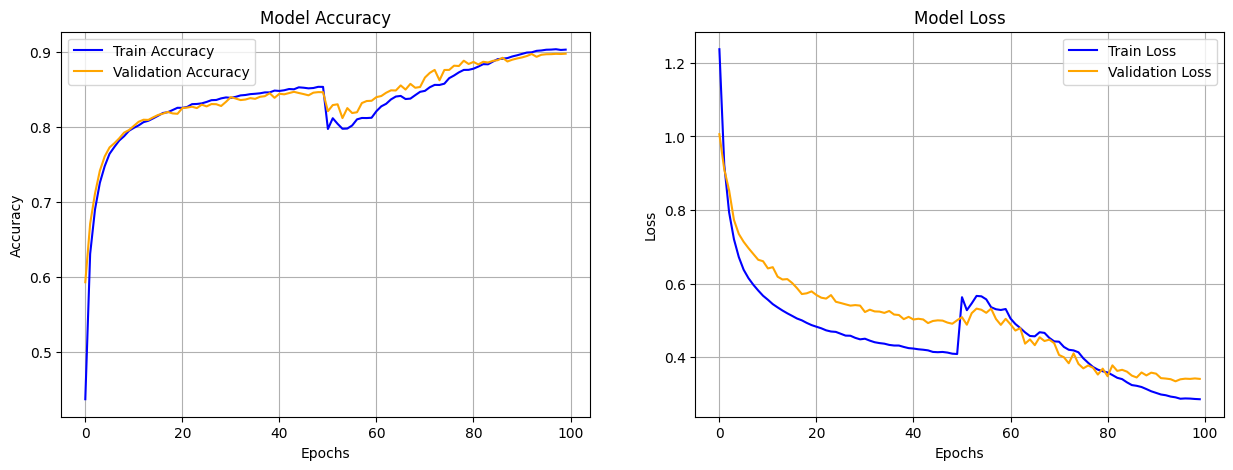

In [18]:
import matplotlib.pyplot as plt

train_losses = history['train_loss']
train_accuracies = history['train_acc']
val_losses = history['val_loss']
val_accuracies = history['val_acc']
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Accuracy
ax1.plot(train_accuracies, label='Train Accuracy', color='blue')
ax1.plot(val_accuracies, label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plotting Loss
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()

In [23]:
best_model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
best_model.load_state_dict(torch.load('runs/adam_from_epoch71/best_model.pth'))
print("Best model loaded and ready for testing.")

Best model loaded and ready for testing.


In [24]:
test_loss, test_acc = evaluate_epoch(best_model, test_dataloader, criterion, DEVICE)

Evaluating: 100%|██████████| 119/119 [00:00<00:00, 172.21it/s, loss=0.3704]


In [25]:
print("-" * 50)
print("Final Test Results:")
print(f"\tTest Loss: {test_loss:.4f}")
print(f"\tTest Accuracy: {test_acc*100:.2f}%")
print("-" * 50)

--------------------------------------------------
Final Test Results:
	Test Loss: 0.3704
	Test Accuracy: 89.37%
--------------------------------------------------
